# Team 4: Trenberth (Sutcliffe) Forcing at a Level
## 1) Imports

In [1]:
import sys
sys.path.append('/home/decker/lab433')

from datetime import datetime

from synoptic import MODEL

from metpy.units import units
from metpy.constants import dry_air_gas_constant as R
from metpy.io import GempakGrid
import metpy.calc as mpcalc
from metpy.plots import FilledContourPlot, MapPanel, PanelContainer

## 2) Get the data

In [2]:
gem_file_name = MODEL + 'nam/24101612_nam211.gem'
gem_file = GempakGrid(gem_file_name)

In [3]:
plot_time = datetime(2024, 10, 16, 18)

pressure = 500
hgt = gem_file.gdxarray(parameter='HGHT', date_time=plot_time, level= pressure)[0] * units('m')
hght = mpcalc.smooth_gaussian(hgt, 16)
T = gem_file.gdxarray(parameter='TMPK', date_time=plot_time, level= pressure)[0] * units('K')
temp = mpcalc.smooth_gaussian(T, 16)

## 3) Calculate

In [4]:
dTempX = mpcalc.first_derivative(temp, axis = 'x')
dTempY = mpcalc.first_derivative(temp, axis = 'y')
dTempIhat = (0 - dTempY.squeeze(dim = 'pres'))
dTempJhat = (dTempX.squeeze(dim = 'pres'))

uV, vV = mpcalc.geostrophic_wind(hght)
geovort = mpcalc.vorticity(uV, vV)
vortAdv1 = mpcalc.advection(geovort, dTempIhat, dTempJhat)
vortAdv = vortAdv1.squeeze(dim = 'pres')                  
                           
F = ((2*R)/pressure) * (vortAdv)

## 4) Plot it

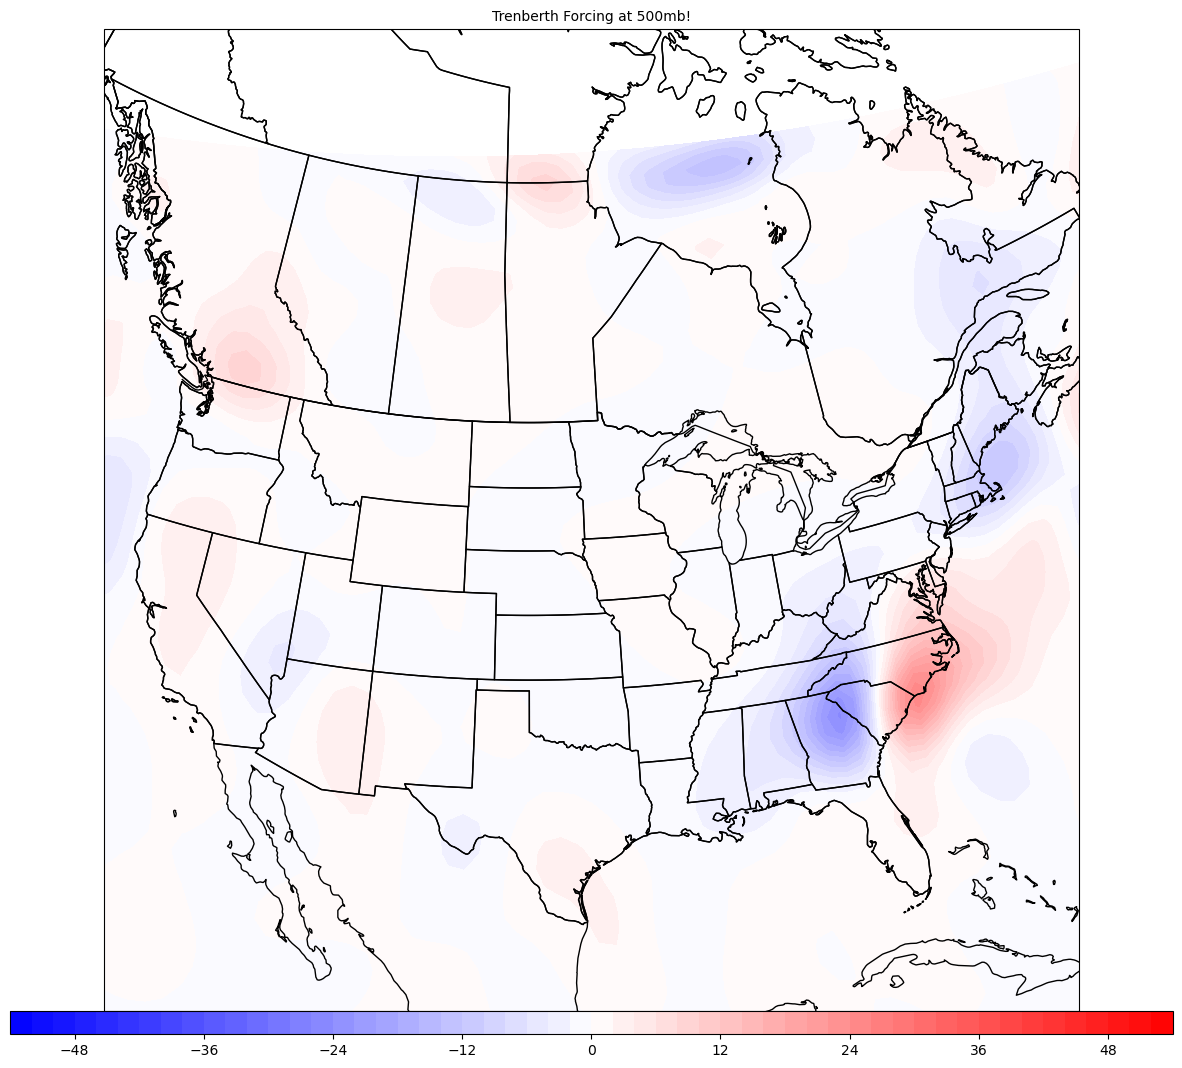

In [5]:
Tren = FilledContourPlot()
Tren.data = F
Tren.time = plot_time
Tren.contours = range(-54,55,2)
Tren.scale = 5e15
Tren.colormap = 'bwr'
Tren.colorbar = 'horizontal'
Tren.clabels = True

panel1 = MapPanel()
panel1.area = [-120, -74, 22, 65]
panel1.projection = 'lcc'
panel1.layers = ['states', 'coastline', 'borders']
panel1.title = f'Trenberth Forcing at {pressure}mb!'
panel1.plots = [Tren]

pc = PanelContainer()
pc.size = (15, 15)
pc.panels = [panel1]
pc.show()